# Bob Ross or Not?
# Detecting Imitations of Bob Ross Paintings using Convolution Neural Networks

Bob Ross was one of the most prolific painters from the 20th Century. He painted over 30,000 works during his lifetime. Many people know him from his TV show, The Joy of Painting, that ran on PBS from 1983 to 1994. Bob Ross invited viewers of his show to learn and enjoy painting, particularily in his style of 'wet on wet' painting, leading to many amateur imitators and fans of his style. Currently, and despite his prolific career, very few paintings are publicly known to be owned or sold. According to the New York Times, many of his paintings are currently stored at the headquarters of Bob Ross Inc., and some are even part in the collection of the Smithsonian Institution .

# Business Understanding

There are no official authenicators of Bob Ross' work and paintings. Furthermore, because of his many fans, there are thousands of paintings made by amateur and professional imitators of his style. Some fakes and many imitations are sold across the internet, but is there a way to authenticate any work to the artist?

Detecting fakes of artwork is a difficult task in machine learning. Due to the similarity between real artworks and fakes, it can be hard to find the differences between images. This notebook attempts to use a convolutional neural network that can be trained to recognize the work of Bob Ross, from any imitation. Furthermore, it can theoretically be used to authenticate any artist, or detect anomalies in medical imaging, and many other fields of machine learning.

# Data Understanding

Bob Ross painted 30,000 works in his lifetime, but relatively very few images are publicly available for download on the internet. The Joy of Painting ran 403 episodes and for every episode, Bob painted a picture that was captured in video. Twoinchbrush.com is a website dedicated to the work of Bob Ross and has compiled every painting that was painted on air, as well as images submitted from people painting under Bob's broadcasted teaching.

Our dataset includes the 403 paintings that Bob painted on the Joy of Painting, captured from Youtube screenshots, as well as any additional paintings that can be verified to be Bob's, found on the internet. In addition to the original artworks, we have included the full set of imitators artworks collected from Twoinchbrush.com to use in comparison.

When it comes to detecting fakes in artworks, it would be ideal to use extremely high resolution images of the work, in order to see all details in the color information of each painting, but at this time this is all we can acquire.

# Problems and Possible Solutions

Our training set is very small, and there is a massive class imbalance between real Bob Ross paintings and paintings by imitators. Also, some images are high resolution and downsampling these images before insertion to the neural network, leads to a loss of information that could be important in modeling and determining the true artist. 

In order to create a larger training set and improve the accuracy of the model, we implemented an idea from this article (link!) that found a possible solution to the class imbalance and small training set problem for detecting fakes of artworks. First, we slice up the images into small tiles that are samples of each painting. Then we take the tiles with the highest entropies, using Claude Shannon's formula for information content, and add rthose to the training set. By using subsets of the information of each painting, the model focuses on the details of each painting, without having to downsample an entire high resolution painting to a small image that can be inserted into the neural network. In effect, we use the parts of the painting that have the highest levels of information while also multiplying the size of the training set by many times.

# Our Model

For this experiment, we used a multi-layer convolutional neural network with 4 convolutional layers followed by max pooling layers. After the convolutional layers, I used one fully connected layer before the final one node layer that determines the authenticity of each artwork. Additionally, we added a dropout layer of 10% after the first convolutional layer.

The final model has around 95% validation accuracy for determining whether an artwork is by Bob Ross or not.

# Predictions

Since we slice up each image into tiles before training our model, we will need to do the same when predicting any additional works that go through the model. We created a helper function that slices up each image, takes 10 tiles with the highest informational entropy and predicts the artist based on the mean of those 10 predictions. Therefore, by pooling the predictions of each tile, even if the accuracy of the model is 95%, the final accuracy will be the equvilent of multiplying that 95% accuracy probability ten times, which would lead to a 59% approximate accuracy overall. If selecting less tiles when predicting each work, the model is more accurate, but uses much less information for prediction.

# The Model

TL;DR

Here is the code used to load images, find slices with the highest entropy, and train the network.

In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Load in the images

All of the scraped and manually collected images are placed into two folders, 'bob' and 'not_bob'. We will grab the information from each file to do some intial analysis on the dataset and put the files into the pipeline for modeling.

In [2]:
#load images from each directory into a list

bob_directory = 'data/images/all_images/bob/'
bob_imgs = os.listdir(bob_directory)

not_bob_directory = 'data/images/all_images/not_bob/'
not_bob_imgs = os.listdir(not_bob_directory)

In [3]:
#helper function to create a title column in the dataframe based on the title of the file
def create_title(x):
    try:
        return x.split('_')[0]
    except:
        return x
    

#helper function to create a dataframe from the files in each directory    
def create_df(images, directory, bob=False):
    df = pd.DataFrame(images)
    df.columns = ['filename']
    df['title'] = df['filename'].apply(create_title)
    df['filetype'] = df['filename'].apply(lambda x: x.split('.')[-1])
    df['fullpath'] = directory + df['filename']
    if bob:
        df['target'] = 'bob'
    else:
        df['target'] = 'not_bob'
    
    return df

bob_df = create_df(bob_imgs, bob_directory, bob=True)
not_bob_df = create_df(not_bob_imgs, not_bob_directory)

In [4]:
bob_df.head()

,filename,title,filetype,fullpath,target
0,cabin-hideaway_5390.png,cabin-hideaway,png,data/images/all_images/bob/cabin-hideaway_5390...,bob
1,autumn-mountain_405.png,autumn-mountain,png,data/images/all_images/bob/autumn-mountain_405...,bob
2,forest-hills_3676.png,forest-hills,png,data/images/all_images/bob/forest-hills_3676.png,bob
3,towering-glacier_4316.png,towering-glacier,png,data/images/all_images/bob/towering-glacier_43...,bob
4,mountain-serenity_10523.jpg,mountain-serenity,jpg,data/images/all_images/bob/mountain-serenity_1...,bob


In [5]:
not_bob_df.head()

,filename,title,filetype,fullpath,target
0,northern-lights_3366.jpg,northern-lights,jpg,data/images/all_images/not_bob/northern-lights...,not_bob
1,golden-glow_4439.jpg,golden-glow,jpg,data/images/all_images/not_bob/golden-glow_443...,not_bob
2,double-oval-stream_6438.jpg,double-oval-stream,jpg,data/images/all_images/not_bob/double-oval-str...,not_bob
3,red-sunset_3599.jpg,red-sunset,jpg,data/images/all_images/not_bob/red-sunset_3599...,not_bob
4,blue-winter_7250.jpg,blue-winter,jpg,data/images/all_images/not_bob/blue-winter_725...,not_bob


Now that we have two dataframe with the images from each folder, let's combine everything into one Dataframe.

In [6]:
all_bob = pd.concat([bob_df, not_bob_df]).reset_index(drop=True)

In [7]:
all_bob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10591 entries, 0 to 10590
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  10591 non-null  object
 1   title     10591 non-null  object
 2   filetype  10591 non-null  object
 3   fullpath  10591 non-null  object
 4   target    10591 non-null  object
dtypes: object(5)
memory usage: 413.8+ KB


In [8]:
all_bob.filetype.value_counts()

jpg     10152
png       408
webp       30
jpeg        1
Name: filetype, dtype: int64

# EDA

The first thing we want to look at is the balance of each class in the dataframe.

In [9]:
print(f'''Bob Ross: Authentic vs. Not - Class Sizes

{all_bob.target.value_counts()}

{all_bob.target.value_counts(normalize=True)}
      ''')

Bob Ross: Authentic vs. Not - Class Sizes

not_bob    10090
bob          501
Name: target, dtype: int64

not_bob    0.952696
bob        0.047304
Name: target, dtype: float64
      


As you can see, we have over 10,000 images of fan paintings, and only 500 paintings that are actually Bob Ross'.

For now that's not too big of problem, since we will slice each image up and multiply our training set by the number of slices we keep.

Now, let's start looking at the entropy for each image.

In [10]:
from PIL import Image
import PIL
import numpy as np
from matplotlib import pyplot as plt

In [11]:
#function to calculate the entropy of any array of numbers
def entropy(signal):
        lensig = signal.size
        symset = list(set(signal))
        numsym = len(symset)
        propab = [np.size(signal[signal == i]) / (1.0*lensig) for i in symset]
        ent = np.sum([p*np.log2(1.0/p) for p in propab])
        return ent

#plot a color image, greyscale image, and the heatmap of the entropy for each 10x10 pixel slice in the image
def plot_entropy(path):    
    colorIm = Image.open(path)
    greyIm = colorIm.convert('L')
    colorIm = np.array(colorIm)
    greyIm = np.array(greyIm)

    N = 5
    S = greyIm.shape
    E = np.array(greyIm)
    for row in range(S[0]):
            for col in range(S[1]):
                    Lx = np.max([0,col-N])
                    Ux = np.min([S[1],col+N])
                    Ly = np.max([0,row-N])
                    Uy = np.min([S[0],row+N])
                    region = greyIm[Ly:Uy,Lx:Ux].flatten()
                    E[row,col] = entropy(region)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(colorIm)
    plt.xlabel('Original Color Image')

    plt.subplot(1,3,2)
    plt.imshow(greyIm, cmap=plt.cm.gray)
    plt.xlabel('Grayscale Image')

    plt.subplot(1,3,3)
    plt.imshow(E, cmap=plt.cm.jet)
    plt.xlabel('Entropy in 10x10 neighbourhood')
    plt.colorbar()

    plt.show()

This graph shows the 10x10 pixel entropies in the entire image of an actual Bob Ross painting selected from our training set.

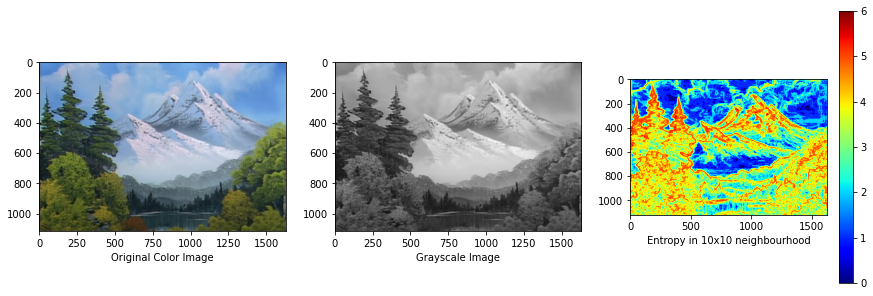

In [12]:
plot_entropy(bob_df.loc[499, 'fullpath'])

And now, let's look at the entropy of a painting by a fan.

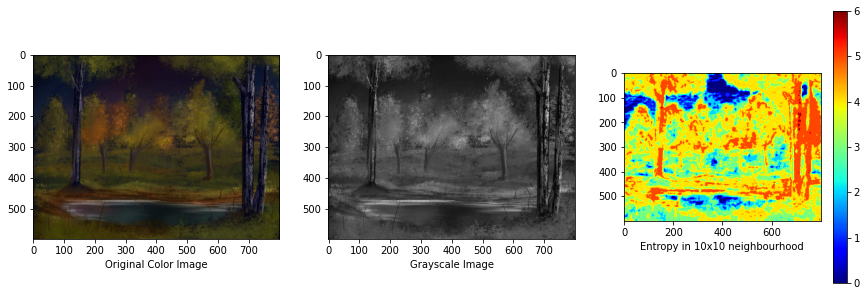

In [13]:
plot_entropy(not_bob_df.loc[37, 'fullpath'])

We can already see that there are parts of the painting that have a higher entropy then others. Entropy is basically the total amount of information that is in each small part of the image. If there is a great variance in the data for each group of pixels, the entropy for that group will be high. If a group of pixels have relatively the same level of colors in it, that entropy will be lower.

Let's look at the average entropiesfrom a sample of 500 different paintings from each class.

In [14]:
entropies = []
for i in range(500):
    img = np.array(Image.open(bob_df.loc[i, 'fullpath']).convert('L')).flatten()
    entropies.append((entropy(img), bob_df.target[i], i))
    
for i in range(500):
    img = np.array(Image.open(not_bob_df.loc[i, 'fullpath']).convert('L')).flatten()
    entropies.append((entropy(img), not_bob_df.target[i], i))

In [15]:
entropy_df = pd.DataFrame(entropies)
entropy_df.columns = ['entropy', 'target', 'index']

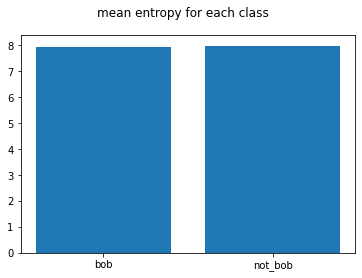

In [16]:
plt.bar(x='target', height='entropy', data=entropy_df)
plt.suptitle('mean entropy for each class')
plt.show()

Here we can see, that the average entropies for paintings by Bob Ross and those not by Bob Ross are virtually the same. This is expected since the images are very similiar and the variance of color in each image is about the same overall.

# Train Test Split

Now let's split up all the images into training and testing sets. After we split them, we will slice each up into 100 tiles and take 10 images with the highest entropies, thereby multiplying our original 500 Bob Ross painting and 500 imitations by a factor of 10.

In [17]:
#Shuffle the entire dataset and then take every Bob Ross painting plus a random imitation and put this in a new DataFrame

img_dataset_df = all_bob.groupby('target').sample(len(bob_df), random_state=42).sample(frac=1, random_state=42)

In [18]:
img_dataset_df

,filename,title,filetype,fullpath,target
1214,misty-rolling-hills_3141.jpg,misty-rolling-hills,jpg,data/images/all_images/not_bob/misty-rolling-h...,not_bob
8913,change-of-seasons_7023.jpg,change-of-seasons,jpg,data/images/all_images/not_bob/change-of-seaso...,not_bob
812,mountain-by-the-sea_3770.jpg,mountain-by-the-sea,jpg,data/images/all_images/not_bob/mountain-by-the...,not_bob
2826,campers-haven_6580.jpg,campers-haven,jpg,data/images/all_images/not_bob/campers-haven_6...,not_bob
161,winter-cabin_2809.png,winter-cabin,png,data/images/all_images/bob/winter-cabin_2809.png,bob
...,...,...,...,...,...
301,christmas-eve-snow_5896.png,christmas-eve-snow,png,data/images/all_images/bob/christmas-eve-snow_...,bob
183,reflections-of-calm_10274.png,reflections-of-calm,png,data/images/all_images/bob/reflections-of-calm...,bob
3946,silent-forest_7688.jpg,silent-forest,jpg,data/images/all_images/not_bob/silent-forest_7...,not_bob
52,ab0108384c4ca304de669aed831d5bf1_grande.webp,ab0108384c4ca304de669aed831d5bf1,webp,data/images/all_images/bob/ab0108384c4ca304de6...,bob


The test set will be 20% of the original dataset. Since the DataFrame is already shuffle, we will simply split the set on the 80% index, for training and testing sets.

In [19]:
train_test_split = 0.8
split_index = int(len(img_dataset_df)*train_test_split)
split_index
train_df = img_dataset_df[:split_index]
test_df = img_dataset_df[split_index:]

Let's confirm that the class balance is equal for each the training and testing sets.

In [20]:
train_df.target.value_counts()

not_bob    401
bob        400
Name: target, dtype: int64

In [21]:
test_df.target.value_counts()

bob        101
not_bob    100
Name: target, dtype: int64

The classes are nearly perfectly balanced for each set. Let's slice each image up and take tiles with the highest entropies.

In [22]:
def slice_image(image_path, num_slices, img_size):
    
    #The target size for each tile will be 256x256
    img_width = img_size[0]
    img_height = img_size[1]

    #This variable will adjust the scale of detail to use in each tile
    img_ratio = 2

    #Some images are not high resolution, and some are, but we will resize every image to the same height and width,
    #so the proportions of the image details are relatively the same.
    full_img_height = int(img_width*(num_slices/img_ratio))
    full_img_width = int(img_height*(num_slices/img_ratio))
        
    #resize each image
    test_img = Image.open(image_path).resize((full_img_height, full_img_width), PIL.Image.BICUBIC)
    #convert to numpy array
    test_img_array = np.array(test_img)
    
    #stride lengths
    height_stride = (test_img_array.shape[0] // num_slices)*img_ratio
    width_stride = (test_img_array.shape[1] // num_slices)*img_ratio
    
    #initialize empty list for storing entropy scores
    img_entropy = []
    
    #loop through each slice of the image and calculate the entropy
    for i in range(num_slices):
        for j in range(num_slices):
            img_slice = test_img_array[i*height_stride:i*height_stride+height_stride, j*width_stride:j*width_stride+width_stride]
            slice_entropy = entropy(img_slice.flatten())
            img_entropy.append((slice_entropy, i, j, img_slice))
            
    return np.array(sorted(img_entropy, reverse=True))[:num_slices,3]
            
def save_images(row, folder_path):

    #create directories to copy images to
    try:
        os.mkdir(folder_path)
        os.mkdir(folder_path+'/'+'bob')
        os.mkdir(folder_path+'/'+'not_bob')
    except:
        pass
            
    #store the top entropy score of all the tiles and select only the top score as well as only the image information
    top_entropies = slice_image(row.fullpath, 10, (256,256))
    
    #save each slice as an image file
    for i in range(num_images_per_image):
        Image.fromarray(top_entropies[i]).resize((img_height, img_width)).save(f'{folder_path}/{row.target}/{row.filename.split(".")[0]}_{i}.jpg')

In [23]:
train_directory = 'data/images/train'
val_directory = 'data/images/test'

#run the function on each dataframe
#train_df.apply(save_images, folder_path=train_directory, axis=1)
#test_df.apply(save_images, folder_path=val_directory, axis=1)

print('Finished Processing Training and Validation Sets')

Finished Processing Training and Validation Sets


# Build Dataset

We will now load the images we created into Tensorflow Dataset objects. Each dataset object is a generator that the network will use to collect batches from.

In [24]:
import tensorflow as tf

batch_size = 32

img_width = 256
img_height = 256

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                        )

val_ds = tf.keras.utils.image_dataset_from_directory(directory=val_directory,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                    )

Found 7970 files belonging to 2 classes.
Using 6376 files for training.
Metal device set to: Apple M1 Pro
Found 2010 files belonging to 2 classes.
Using 402 files for validation.


2022-08-05 13:58:43.032910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-05 13:58:43.033057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In case there is any information in each image that might be localized to one position in the frame, we will use this image augmentation function, that will flip the image randomly every time it enters the network.

In [25]:
def augment_using_ops(images, labels):
    scale=1./255
    images=images*scale
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    return (images, labels)

train_ds = train_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Model

For our model, we used a fairly shallow neural network with multiple convolutional layers, followed by one fully connected layer. One dropout layer is added after the first convolutional layer. We used Adam as an optimizer, and used a Early Stopping function, that stops training if the validation accuracy does not improve after 20 epochs.

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential([
    Conv2D(input_shape=(img_height, img_width, 3), filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Dropout(.1),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=512,activation="relu"),
    Dense(units=1, activation='sigmoid')
])


steps_per_epoch = len(train_ds)

validation_steps = len(val_ds)

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', restore_best_weights=True, patience=20)

In [ ]:
hist = model.fit(train_ds.repeat(),
                        steps_per_epoch=steps_per_epoch,
                        epochs=100,
                        validation_data=val_ds,
                        validation_steps=validation_steps,
                        callbacks=early_stopping)

Epoch 1/100


2022-08-05 15:26:23.070996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 0.7072 - acc: 0.6468

2022-08-05 15:28:12.465669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 112s 523ms/step - loss: 0.7072 - acc: 0.6468 - val_loss: 0.4304 - val_acc: 0.8433
Epoch 2/100
200/200 [==============================] - 112s 521ms/step - loss: 0.4262 - acc: 0.8264 - val_loss: 0.3754 - val_acc: 0.8682
Epoch 3/100
200/200 [==============================] - 111s 519ms/step - loss: 0.3317 - acc: 0.8703 - val_loss: 0.3463 - val_acc: 0.8532
Epoch 4/100
200/200 [==============================] - 112s 523ms/step - loss: 0.3087 - acc: 0.8777 - val_loss: 0.2510 - val_acc: 0.9055
Epoch 5/100
200/200 [==============================] - 111s 522ms/step - loss: 0.2688 - acc: 0.9013 - val_loss: 0.2715 - val_acc: 0.9030
Epoch 6/100
200/200 [==============================] - 112s 523ms/step - loss: 0.2300 - acc: 0.9089 - val_loss: 0.2365 - val_acc: 0.9204
Epoch 7/100
200/200 [==============================] - 112s 522ms/step - loss: 0.1900 - acc: 0.9261 - val_loss: 0.2515 - val_acc: 0.9055
Epoch 8/100
200/200 [==============================] 

In [ ]:
model.save_weights('./data/model_trained')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'], label='Training')
plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'], label='Validation')
plt.suptitle('Model Training - Loss by Epoch')
plt.legend()
plt.show()

The loss graph shows there is a slight amount of overfitting by the end of training.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['acc'])), hist.history['acc'], label='Training')
plt.plot(range(len(hist.history['val_acc'])), hist.history['val_acc'], label='Validation')
plt.suptitle('Model Training - Accuracy by Epoch')
plt.legend()
plt.show()

Regardless of a slight amount of overfitting, the validation accuracy is very close to the 

# Predictions

Now, let's write a quick helper function to predict if an image is a Bob Ross painting or not. First, we will have to preprocess the image by slicing it into small tiles with high entropy to be run through the model. Then we will take the array of predictions from each tile and calculate the mean. The rounded mean of the prediction array will be our overall prediction for each image.

In [ ]:
def predict_image(image_path, num_tiles=10, label=None, show_image=True):
    
    batch_size = num_tiles
    
    test_img = Image.open(image_path)
    
    top_entropies = slice_image(image_path, num_tiles, (256,256))
    batch = np.array([np.array(img) for img in top_entropies])
    predictions = model.predict(batch)
    
    if show_image:
        fig = plt.imshow(test_img)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.show()

        print(predictions.T.round())

        print('file:',image_path)
    
    
        if round(predictions.mean()) == 0:

            print('The model predicts this is a Bob Ross painting.')
            if label != None:
                if label:
                    print('And this is correct.')
                else:
                    print('And this is not correct.')
        else:
            print('The model predicts this is not Bob Ross painting.')
            if label != None:
                if label:
                    print('And this is not correct.')
                else:
                    print('And this is correct.')
    else:        
        return round(predictions.mean())


Now we can try using a few images in the model to see how well it can predict from a full image.

The images we will use are:

- A painting by Steve Ross, Bob Ross' son
- A painting by Bob Ross that was not used in training or validation
- A fan painting in the Bob Ross style, not using in training
- A Bob Ross painting from the validation set
- A fan painting from the validation set
- Van Gogh's Starry Night

In [ ]:
predict_image('data/steve-ross-painting.webp', label=False) #steve ross painting
predict_image('data/bob-ross-painting.png', label=True) # bob ross painting not used in training
predict_image('data/not_bob_ross.webp', label=False) # fan painting
predict_image('data/images/all_images/bob/night-light_1420.png', label=True) #bob ross painting from the validation set
predict_image('data/images/all_images/not_bob/a-perfect-winter-day_9946.jpg', label=False) #fan painting from the validation set
predict_image('data/van-gogh-starry-night.jpeg', label=False) #van gogh - starry night

Looks like the model is working very well at predicting whole images.

We will run the full images from the validation set, plus 500 fan paintings that we not used, to test the accuracy of the model.

In [ ]:
#get images from the whole dataset that were not used in training or validation
not_used_index = [index for index in all_bob.index if index not in train_df.index and index not in test_df.index]
testing_set = all_bob.loc[not_used_index]
#slice 500 of the unused images, and add the validation set
testing_set = pd.concat([testing_set[:500],test_df])

In [ ]:
#create the array of ground truth labels
y_true = (testing_set.target != 'bob').astype(int)

In [ ]:
#run predictions for each image in the test set and save the predictions in y_hat
y_hat = []
for idx, row in testing_set.reset_index().iterrows():
    y_hat.append(predict_image(row.fullpath, num_tiles=10, show_image=False))
    print(f'{idx+1} / {len(testing_set)}', end='\r')

Plot the confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

confusion = confusion_matrix(y_true, y_hat)

ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels = ['Bob Ross', 'Not Bob Ross']).plot()

Accuracy Score for testing set

In [ ]:
accuracy_score(y_true, y_hat)

Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_hat))

# Results 

According to our test set, our model is able to correctly classify whether a painting is an original Bob Ross painting with over 90% accuracy, even when the painting is in the 'Bob Ross Style' or painted under his instruction. 

We believe this model proves that an artist's style and unique way of creating is not duplicatable, and that machine learning can be used to detect forgeries in artworks. Even when an artwork closely resembles the original artwork or artist, our model can correctly classify the artist's handiwork.

Moreover, we believe this method has wide ranging implications in the field of image analysis. A similiar preprocessing technique of slicing an image in sections and retaining the most important information, as described in this paper, can be used as a general model for detecting forgeries in artworks by other artists, but also as a tool for correctly classifying anomalies in other images, such as in the field of medical imaging analysis.

Our next steps, include augmenting our dataset with higher quality images of the work of Bob Ross, as well as extending this model to detect the forgeries of other major artists that have limited dataset or small samples of work publicly available.